<a href="https://colab.research.google.com/github/Orange314159/DataScience/blob/main/MattRobsU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q "preliz[full,notebook]" ## use -q to reduce the included text for download

In [2]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import arviz as az
import pymc as pm
import altair as alt
import seaborn as sns
import math
import pandas as pd

# Sleep Tracking (again again)

## Context
In this project I will further discover the extent to the poor sleep of my subject. I will be using the same period of time as in projects two and three where I measure the ammount of sleep of my subject, but in this case I will be using the exact sleep amount, rather than looking only at the data of one subject, I will use the data of other subjects to support this and improve my priors.

## Likelihood
I will use my data set that he has reported on his sleep. It appears that he has a fairly normally distributed sleep pattern with a slight right skew. Additionally, this looks to have a mean of about 7hrs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<BarContainer object of 10 artists>


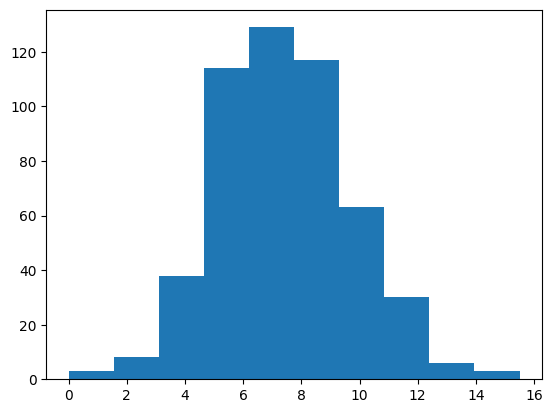

In [4]:
# Using Polars, import the sleep data (a table of 1s and 0s with width of 7)
sleepData = pl.read_csv("/content/drive/MyDrive/DataScience/UnitThreeProjectDataSet.csv")

## plot the data
print(plt.hist(sleepData.to_numpy().flatten())[2])

data = sleepData.to_numpy().flatten()


# Continuation?
As I mentioned in my unit three project, I thought that a skewNormal would be the best model for my data. While I still think this was a good choice, based on feedback from my peers and instructor, I will attempt to use the skewStudentT instead.  
  
From this, I will focus now on my based on the data from other subject's sleep. In my data set, up to this point I have only ever considered the sleep from one subject, but now we can look at the sleep of many other subjects that are similar and use them to help form our priors.

I know that my original subject (Subject0) is similar to Subject1 and Subject2 in terms of sleep because these subjects have similar behavior and have similar factors that lead to their sleep (ie. similar classes taken).  

From here, I will start by defining my priors based on the other data that I have from subjects 1 and 2.

In [5]:
subj1 = pl.read_csv("/content/drive/MyDrive/DataScience/UnitFourDataSet_Subj1.csv")
subj2 = pl.read_csv("/content/drive/MyDrive/DataScience/UnitFourDataSet_Subj2.csv")

Subject 1:

<BarContainer object of 10 artists>


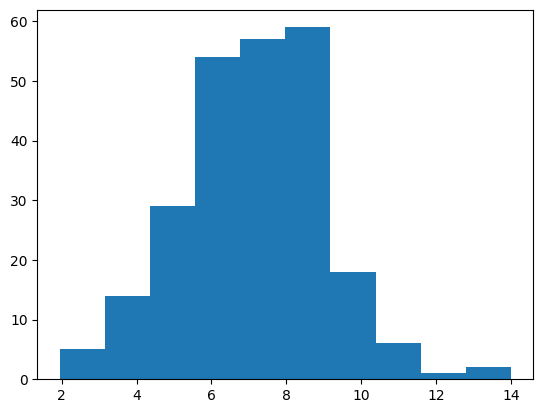

In [6]:
print(plt.hist(subj1.to_numpy().flatten())[2])
subj1_data = subj1.to_numpy().flatten()

Subject 2:

<BarContainer object of 10 artists>


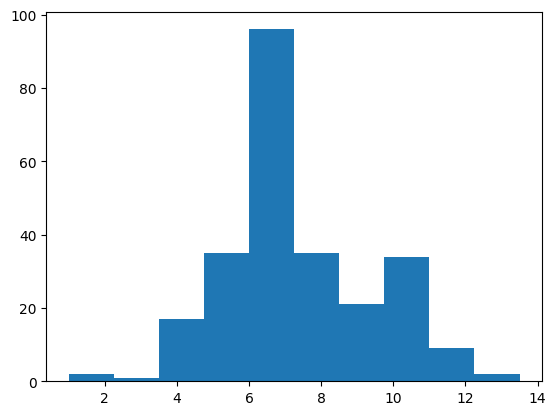

In [7]:
print(plt.hist(subj2.to_numpy().flatten())[2])
subj2_data = subj2.to_numpy().flatten()

## Priors

Ok, it looks like Subject1 look fairly similar to Subject0 in terms of mean, but the stDev looks a little high. On the other hand, Subject2 seems to also have a similar mean, but a lower stDev. Based on this, I think that I was correct in assuming that these other subjects are good informants for my Subject0's priors.  
  
Now let's create those priors!

In [8]:
# Combine the data from all subjects into a single array
all_sleep_data = np.concatenate((data, subj1_data, subj2_data))

# Create a label array to identify the subject for each data point
subject_labels = np.concatenate((np.full_like(data, 'subj0', dtype=object), np.full_like(subj1_data, 'subj1', dtype=object), np.full_like(subj2_data, 'subj2', dtype=object)))

# Combine the data and labels into a Polars DataFrame
combined_sleep_df = pd.DataFrame({
    "sleep_amount": all_sleep_data,
    "subject": subject_labels
})

# Display the first few rows of the combined DataFrame
print(combined_sleep_df)

      sleep_amount subject
0             6.25   subj0
1             8.00   subj0
2             7.25   subj0
3             8.25   subj0
4            10.00   subj0
...            ...     ...
1003          6.00   subj2
1004          9.00   subj2
1005          9.00   subj2
1006          7.00   subj2
1007          7.00   subj2

[1008 rows x 2 columns]


In [9]:
sleep_encode = pd.Categorical(combined_sleep_df['subject'])
sleep_encode

['subj0', 'subj0', 'subj0', 'subj0', 'subj0', ..., 'subj2', 'subj2', 'subj2', 'subj2', 'subj2']
Length: 1008
Categories (3, object): ['subj0', 'subj1', 'subj2']

In [10]:
sleep_idx = sleep_encode.codes
sleep_idx

array([0, 0, 0, ..., 2, 2, 2], dtype=int8)

In [11]:
sleep_coords = {"subject": sleep_encode.categories}
sleep_coords

{'subject': Index(['subj0', 'subj1', 'subj2'], dtype='object')}

In [ ]:
with pm.Model(coords=sleep_coords) as sleep_h_model:
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu=15)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu=15)
    ν_mu = pm.Exponential('ν_alpha', lam=1/30)
    ν_sd = pm.Exponential('ν_beta', lam=1/30)

    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = ν_mu,
                  dims = "subject")

    σ = pm.HalfStudentT('σ', sigma = 10,
                        nu = ν_sd,
                        dims = "subject")
    ν = pm.Exponential('ν', lam=1/30, dims="subject")
    a_prior = pm.Exponential('a_prior', lam=1/30, dims="subject")
    b_prior = pm.Exponential('b_prior', lam=1/30, dims="subject")

    y = pm.SkewStudentT('y',
                  mu = μ[sleep_idx],
                  sigma = σ[sleep_idx],

                  a = a_prior[sleep_idx],
                  b = b_prior[sleep_idx],
                  observed = combined_sleep_df.sleep_amount)

    idata_sleep_h = pm.sample()

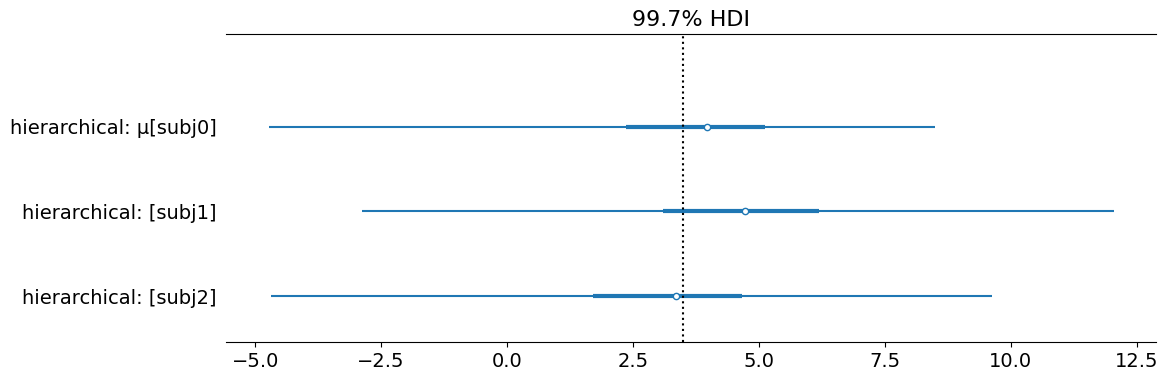

In [13]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_sleep_h], kind="forestplot",
                      model_names=['hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 4),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_sleep_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

## Our Final Model

Output()

<Axes: xlabel='y'>

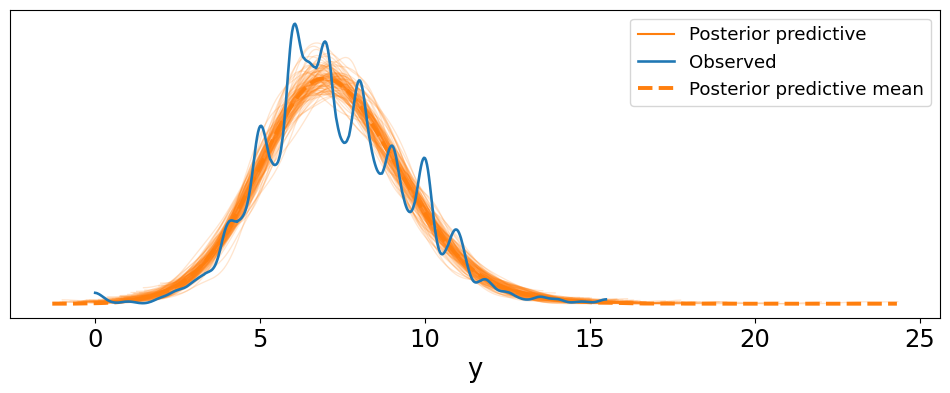

In [16]:
pm.sample_posterior_predictive(idata_sleep_h, model=sleep_h_model, extend_inferencedata=True)
az.plot_ppc(idata_sleep_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Well look at that!  
This models has worked pretty well. This even looks possible a bit better than before in unit three. As we can see from this model it predicts my subjects sleep very close to the observed sleep, and it even makes sense in the context of our situation. We observe some peaks in our data that seem to sugest that there might be a bimodal distribution, but based on the context of this being sleep time data, we would not expect a bimodal distribuation so our posterior is very good for following the data in thi way.

It is also important to note that we did see 96 divergences which might suggest that there is something weird with our data. Most likely I would argue that this comes from the weird aspect of my two bimodal humps, but the number of divergences is not very significant and the model did not break because of it so I think that our model is still good.

## Conclusion

Based on all of this we can say that the heirarchical model did have a small benefit on our old model, but it was not significant. This is because we do get a following of similar sleep between similar students, but it is not that close. This seems like a good improvement, but we also must consider the fact that we have also introduced the use of a skewStudentT over a skewNormal which may also have improved our model's fit.